In [1]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score, confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.tree import plot_tree

In [2]:
# Import our input dataset
df = pd.read_csv('Data/ML_ready_data.csv')
df.head()

,id,season,week,neutral_site,home_team_x,home_conference,home_points,home_pregame_elo,away_team_x,away_conference,away_points,away_pregame_elo,spread,margin
0,400603840.0,2015.0,1.0,True,South Carolina,SEC,17.0,1646.0,North Carolina,ACC,13.0,1477.0,-3.5,-4.0
1,400763593.0,2015.0,1.0,False,UCF,American Athletic,14.0,1626.0,Florida International,Conference USA,15.0,1321.0,-17.0,1.0
2,400763399.0,2015.0,1.0,False,Central Michigan,Mid-American,13.0,1417.0,Oklahoma State,Big 12,24.0,1567.0,20.5,11.0
3,400603839.0,2015.0,1.0,False,Vanderbilt,SEC,12.0,1365.0,Western Kentucky,Conference USA,14.0,1521.0,-17.5,2.0
4,400756883.0,2015.0,1.0,False,Utah,Pac-12,24.0,1603.0,Michigan,Big Ten,17.0,1553.0,-3.0,-7.0


In [3]:
df['week']=df['week'].astype('int64')
df['id']=df['id'].astype('int64')
df['season']=df['season'].astype('int64')

df.head()

,id,season,week,neutral_site,home_team_x,home_conference,home_points,home_pregame_elo,away_team_x,away_conference,away_points,away_pregame_elo,spread,margin
0,400603840,2015,1,True,South Carolina,SEC,17.0,1646.0,North Carolina,ACC,13.0,1477.0,-3.5,-4.0
1,400763593,2015,1,False,UCF,American Athletic,14.0,1626.0,Florida International,Conference USA,15.0,1321.0,-17.0,1.0
2,400763399,2015,1,False,Central Michigan,Mid-American,13.0,1417.0,Oklahoma State,Big 12,24.0,1567.0,20.5,11.0
3,400603839,2015,1,False,Vanderbilt,SEC,12.0,1365.0,Western Kentucky,Conference USA,14.0,1521.0,-17.5,2.0
4,400756883,2015,1,False,Utah,Pac-12,24.0,1603.0,Michigan,Big Ten,17.0,1553.0,-3.0,-7.0


In [4]:
train_df = df.query("season != 2022")
test_df = df.query("season == 2022")

# 2022 Games played prior to week 11
played_df = test_df[test_df['week']<11]
future_df = test_df[test_df['week'] == 11]

In [5]:
# Code used to update data for future prdecitions by replacing spreads with the provided spreads

# Import our input dataset
#W11Lines_df = pd.read_csv('Data/Week11Lines.csv')
#W11Lines_df = W11Lines_df[W11Lines_df.lineProvider == 'Bovada']
# future_df = future_df.drop(columns=["spread"])
# future_df = future_df.merge(W11Lines_df[['id','spread']],on='id', how='left')
future_df=future_df.drop_duplicates(subset='id')
future_df

,id,season,week,neutral_site,home_team_x,home_conference,home_points,home_pregame_elo,away_team_x,away_conference,away_points,away_pregame_elo,spread,margin
5282,401416637,2022,11,False,Akron,Mid-American,28.0,914.0,Eastern Michigan,Mid-American,34.0,1311.0,6.5,6.0
5283,401416638,2022,11,False,Miami (OH),Mid-American,21.0,1439.0,Ohio,Mid-American,37.0,1401.0,2.5,16.0
5284,401416636,2022,11,False,Toledo,Mid-American,28.0,1582.0,Ball State,Mid-American,21.0,1305.0,-13.5,-7.0
5285,401416639,2022,11,False,Western Michigan,Mid-American,21.0,1274.0,Northern Illinois,Mid-American,24.0,1361.0,1.0,3.0
5286,401416641,2022,11,False,Bowling Green,Mid-American,6.0,1183.0,Kent State,Mid-American,40.0,1265.0,2.5,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5341,401415255,2022,11,False,Nevada,Mountain West,3.0,1358.0,Boise State,Mountain West,41.0,1689.0,21.0,38.0
5342,401404034,2022,11,False,UCLA,Pac-12,28.0,1752.0,Arizona,Pac-12,34.0,1300.0,-20.0,6.0
5343,401415257,2022,11,False,Hawai'i,Mountain West,34.0,1074.0,Utah State,Mountain West,41.0,1425.0,10.5,7.0
5363,401405134,2022,11,False,Illinois,Big Ten,24.0,1730.0,Purdue,Big Ten,31.0,1595.0,NaN,NaN


In [6]:
#margins and points verified to be zero for preprocessing predictions
future_df = future_df.fillna(0)
future_df

,id,season,week,neutral_site,home_team_x,home_conference,home_points,home_pregame_elo,away_team_x,away_conference,away_points,away_pregame_elo,spread,margin
5282,401416637,2022,11,False,Akron,Mid-American,28.0,914.0,Eastern Michigan,Mid-American,34.0,1311.0,6.5,6.0
5283,401416638,2022,11,False,Miami (OH),Mid-American,21.0,1439.0,Ohio,Mid-American,37.0,1401.0,2.5,16.0
5284,401416636,2022,11,False,Toledo,Mid-American,28.0,1582.0,Ball State,Mid-American,21.0,1305.0,-13.5,-7.0
5285,401416639,2022,11,False,Western Michigan,Mid-American,21.0,1274.0,Northern Illinois,Mid-American,24.0,1361.0,1.0,3.0
5286,401416641,2022,11,False,Bowling Green,Mid-American,6.0,1183.0,Kent State,Mid-American,40.0,1265.0,2.5,34.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5341,401415255,2022,11,False,Nevada,Mountain West,3.0,1358.0,Boise State,Mountain West,41.0,1689.0,21.0,38.0
5342,401404034,2022,11,False,UCLA,Pac-12,28.0,1752.0,Arizona,Pac-12,34.0,1300.0,-20.0,6.0
5343,401415257,2022,11,False,Hawai'i,Mountain West,34.0,1074.0,Utah State,Mountain West,41.0,1425.0,10.5,7.0
5363,401405134,2022,11,False,Illinois,Big Ten,24.0,1730.0,Purdue,Big Ten,31.0,1595.0,0.0,0.0


In [7]:
games_df = pd.concat([train_df,played_df,future_df],ignore_index=True)
games_df

,id,season,week,neutral_site,home_team_x,home_conference,home_points,home_pregame_elo,away_team_x,away_conference,away_points,away_pregame_elo,spread,margin
0,400603840,2015,1,True,South Carolina,SEC,17.0,1646.0,North Carolina,ACC,13.0,1477.0,-3.5,-4.0
1,400763593,2015,1,False,UCF,American Athletic,14.0,1626.0,Florida International,Conference USA,15.0,1321.0,-17.0,1.0
2,400763399,2015,1,False,Central Michigan,Mid-American,13.0,1417.0,Oklahoma State,Big 12,24.0,1567.0,20.5,11.0
3,400603839,2015,1,False,Vanderbilt,SEC,12.0,1365.0,Western Kentucky,Conference USA,14.0,1521.0,-17.5,2.0
4,400756883,2015,1,False,Utah,Pac-12,24.0,1603.0,Michigan,Big Ten,17.0,1553.0,-3.0,-7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5341,401415255,2022,11,False,Nevada,Mountain West,3.0,1358.0,Boise State,Mountain West,41.0,1689.0,21.0,38.0
5342,401404034,2022,11,False,UCLA,Pac-12,28.0,1752.0,Arizona,Pac-12,34.0,1300.0,-20.0,6.0
5343,401415257,2022,11,False,Hawai'i,Mountain West,34.0,1074.0,Utah State,Mountain West,41.0,1425.0,10.5,7.0
5344,401405134,2022,11,False,Illinois,Big Ten,24.0,1730.0,Purdue,Big Ten,31.0,1595.0,0.0,0.0


In [8]:
football_df = games_df.drop(["id","season","week","home_team_x","away_team_x","home_points","away_points"],axis=1).dropna()
football_df

,neutral_site,home_conference,home_pregame_elo,away_conference,away_pregame_elo,spread,margin
0,True,SEC,1646.0,ACC,1477.0,-3.5,-4.0
1,False,American Athletic,1626.0,Conference USA,1321.0,-17.0,1.0
2,False,Mid-American,1417.0,Big 12,1567.0,20.5,11.0
3,False,SEC,1365.0,Conference USA,1521.0,-17.5,2.0
4,False,Pac-12,1603.0,Big Ten,1553.0,-3.0,-7.0
...,...,...,...,...,...,...,...
5341,False,Mountain West,1358.0,Mountain West,1689.0,21.0,38.0
5342,False,Pac-12,1752.0,Pac-12,1300.0,-20.0,6.0
5343,False,Mountain West,1074.0,Mountain West,1425.0,10.5,7.0
5344,False,Big Ten,1730.0,Big Ten,1595.0,0.0,0.0


In [9]:
football_df.isna().sum()

neutral_site        0
home_conference     0
home_pregame_elo    0
away_conference     0
away_pregame_elo    0
spread              0
margin              0
dtype: int64

In [10]:
# Generate our categorical variable lists
football_cat = football_df.dtypes[football_df.dtypes == "object"].index.tolist()

# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(football_df[football_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names_out(football_cat)
encode_df.head()

,home_conference_ACC,home_conference_American Athletic,home_conference_Big 12,home_conference_Big Ten,home_conference_Conference USA,home_conference_FBS Independents,home_conference_Mid-American,home_conference_Mountain West,home_conference_Pac-12,home_conference_SEC,...,away_conference_American Athletic,away_conference_Big 12,away_conference_Big Ten,away_conference_Conference USA,away_conference_FBS Independents,away_conference_Mid-American,away_conference_Mountain West,away_conference_Pac-12,away_conference_SEC,away_conference_Sun Belt
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Merge one-hot encoded features and drop the originals
merged_df = football_df.merge(encode_df,left_index=True, right_index=True)
merged_df = merged_df.drop(football_cat,axis=1)
merged_df.head()

,neutral_site,home_pregame_elo,away_pregame_elo,spread,margin,home_conference_ACC,home_conference_American Athletic,home_conference_Big 12,home_conference_Big Ten,home_conference_Conference USA,...,away_conference_American Athletic,away_conference_Big 12,away_conference_Big Ten,away_conference_Conference USA,away_conference_FBS Independents,away_conference_Mid-American,away_conference_Mountain West,away_conference_Pac-12,away_conference_SEC,away_conference_Sun Belt
0,True,1646.0,1477.0,-3.5,-4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,False,1626.0,1321.0,-17.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,False,1417.0,1567.0,20.5,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,False,1365.0,1521.0,-17.5,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,False,1603.0,1553.0,-3.0,-7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
#Convert boolean values to int
merged_df["neutral_site"]=merged_df["neutral_site"].astype(int)
merged_df.head()

,neutral_site,home_pregame_elo,away_pregame_elo,spread,margin,home_conference_ACC,home_conference_American Athletic,home_conference_Big 12,home_conference_Big Ten,home_conference_Conference USA,...,away_conference_American Athletic,away_conference_Big 12,away_conference_Big Ten,away_conference_Conference USA,away_conference_FBS Independents,away_conference_Mid-American,away_conference_Mountain West,away_conference_Pac-12,away_conference_SEC,away_conference_Sun Belt
0,1,1646.0,1477.0,-3.5,-4.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,1626.0,1321.0,-17.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,1417.0,1567.0,20.5,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1365.0,1521.0,-17.5,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,1603.0,1553.0,-3.0,-7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
#Investigating Outlier scores 
merged_df.margin.value_counts()

-3.0     277
-7.0     245
 3.0     234
 7.0     210
-14.0    156
        ... 
-67.0      1
 54.0      1
-74.0      1
-62.0      1
 61.0      1
Name: margin, Length: 132, dtype: int64

In [14]:
merged_df.margin.describe()

count    5346.000000
mean       -3.981294
std        21.338100
min       -74.000000
25%       -18.000000
50%        -3.000000
75%         8.000000
max        78.000000
Name: margin, dtype: float64

(array([  18.,  160.,  481., 1078., 1472., 1301.,  585.,  203.,   43.,
           5.]),
 array([-74. , -58.8, -43.6, -28.4, -13.2,   2. ,  17.2,  32.4,  47.6,
         62.8,  78. ]),
 <BarContainer object of 10 artists>)

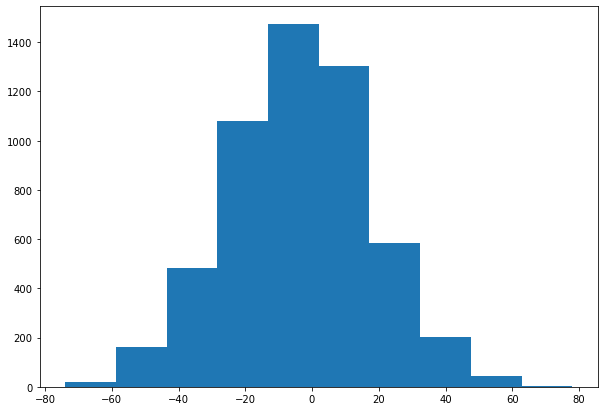

In [15]:
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(merged_df.margin)

In [16]:
#Retrieve stats for equations of limits
mu = np.average(merged_df.margin)
sigma = np.std(merged_df.margin)
    
#Set boundaries
lowerb = mu - 2*sigma # Lower limit 
upperb = mu + 2*sigma # Upper limit
    
#update outliers to boundary limits
merged_df['margin']= merged_df['margin'].clip(lowerb, upperb)

(array([287., 343., 437., 719., 875., 930., 682., 441., 317., 315.]),
 array([-46.65350339, -38.1190616 , -29.58461981, -21.05017801,
        -12.51573622,  -3.98129443,   4.55314737,  13.08758916,
         21.62203096,  30.15647275,  38.69091454]),
 <BarContainer object of 10 artists>)

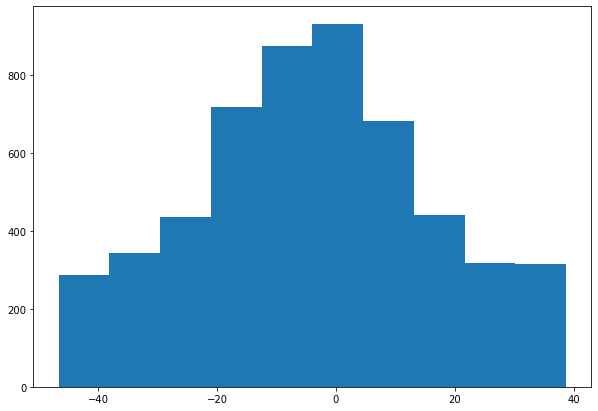

In [17]:
# Updated histogram with the boundaries established to allow stratification
fig, ax = plt.subplots(figsize =(10, 7))
ax.hist(merged_df.margin)

In [18]:
# Split our preprocessed data into our features and target arrays
y = merged_df.margin
X = merged_df.drop(columns=["margin"])

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)
print(y.shape, X.shape)

# Create a StandardScaler instance
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

(5346,) (5346, 26)


In [19]:
# Saving feature names for later use
feature_list = list(merged_df.columns)

# The baseline predictions are the historical averages
baseline_preds = X_test_scaled[:, feature_list.index('margin')]

# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - y_test)

print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  16.79


In [20]:
# Create a random forest model
rf_model = RandomForestRegressor(n_estimators=512, random_state=1, verbose=2)

# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)

# Calculate the absolute errors
errors = abs(y_pred - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


building tree 1 of 512
building tree 2 of 512
building tree 3 of 512
building tree 4 of 512
building tree 5 of 512
building tree 6 of 512
building tree 7 of 512
building tree 8 of 512
building tree 9 of 512
building tree 10 of 512
building tree 11 of 512
building tree 12 of 512
building tree 13 of 512
building tree 14 of 512
building tree 15 of 512
building tree 16 of 512
building tree 17 of 512
building tree 18 of 512
building tree 19 of 512
building tree 20 of 512
building tree 21 of 512
building tree 22 of 512
building tree 23 of 512
building tree 24 of 512
building tree 25 of 512
building tree 26 of 512
building tree 27 of 512
building tree 28 of 512
building tree 29 of 512
building tree 30 of 512
building tree 31 of 512
building tree 32 of 512
building tree 33 of 512
building tree 34 of 512
building tree 35 of 512
building tree 36 of 512
building tree 37 of 512
building tree 38 of 512
building tree 39 of 512
building tree 40 of 512
building tree 41 of 512
building tree 42 of 512
b

building tree 337 of 512
building tree 338 of 512
building tree 339 of 512
building tree 340 of 512
building tree 341 of 512
building tree 342 of 512
building tree 343 of 512
building tree 344 of 512
building tree 345 of 512
building tree 346 of 512
building tree 347 of 512
building tree 348 of 512
building tree 349 of 512
building tree 350 of 512
building tree 351 of 512
building tree 352 of 512
building tree 353 of 512
building tree 354 of 512
building tree 355 of 512
building tree 356 of 512
building tree 357 of 512
building tree 358 of 512
building tree 359 of 512
building tree 360 of 512
building tree 361 of 512
building tree 362 of 512
building tree 363 of 512
building tree 364 of 512
building tree 365 of 512
building tree 366 of 512
building tree 367 of 512
building tree 368 of 512
building tree 369 of 512
building tree 370 of 512
building tree 371 of 512
building tree 372 of 512
building tree 373 of 512
building tree 374 of 512
building tree 375 of 512
building tree 376 of 512


[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:   13.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Mean Absolute Error: 12.67


[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:    0.3s finished


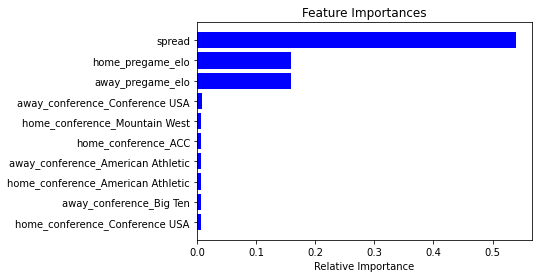

In [21]:
plt.title('Feature Importances')

top_features = 10
features = X.columns
importances = rf_model.feature_importances_
index = np.argsort(importances)

plt.barh(range(top_features), importances[index[-top_features:]], color='b', align='center')
plt.yticks(range(top_features), [features[i] for i in index[-top_features:]])
plt.xlabel('Relative Importance')
plt.show()

In [22]:
X_predict = scaler.fit(X)
X_predict_scaled = X_predict.transform(X)
prediction = rf_model.predict(X_predict_scaled)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 512 out of 512 | elapsed:    0.8s finished


In [23]:
r2_score(y,prediction)

0.7391701496781881

In [24]:
predict_df = pd.DataFrame([games_df.season,
                           games_df.week,
                           games_df.home_team_x,
                           games_df.home_points,
                           games_df.away_team_x,
                           games_df.away_points,
                           games_df.spread,
                           games_df.margin,
                           prediction]).transpose()
predict_df.rename(columns = {"Unnamed 0":"PREDICTION"}, inplace = True)
predict_df

,season,week,home_team_x,home_points,away_team_x,away_points,spread,margin,PREDICTION
0,2015,1,South Carolina,17.0,North Carolina,13.0,-3.5,-4.0,-6.234375
1,2015,1,UCF,14.0,Florida International,15.0,-17.0,1.0,-6.584584
2,2015,1,Central Michigan,13.0,Oklahoma State,24.0,20.5,11.0,13.784801
3,2015,1,Vanderbilt,12.0,Western Kentucky,14.0,-17.5,2.0,-17.671875
4,2015,1,Utah,24.0,Michigan,17.0,-3.0,-7.0,-6.361328
...,...,...,...,...,...,...,...,...,...
5341,2022,11,Nevada,3.0,Boise State,41.0,21.0,38.0,30.271733
5342,2022,11,UCLA,28.0,Arizona,34.0,-20.0,6.0,-2.960184
5343,2022,11,Hawai'i,34.0,Utah State,41.0,10.5,7.0,8.638814
5344,2022,11,Illinois,24.0,Purdue,31.0,0.0,0.0,-0.496094


In [25]:
# Return only week 11 games
Week11_predictions_df = predict_df[(predict_df["season"] == 2022) & (predict_df["week"] == 11)].reset_index(drop=True)
Week11_predictions_df

,season,week,home_team_x,home_points,away_team_x,away_points,spread,margin,PREDICTION
0,2022,11,Akron,28.0,Eastern Michigan,34.0,6.5,6.0,15.648196
1,2022,11,Miami (OH),21.0,Ohio,37.0,2.5,16.0,6.347656
2,2022,11,Toledo,28.0,Ball State,21.0,-13.5,-7.0,-11.049873
3,2022,11,Western Michigan,21.0,Northern Illinois,24.0,1.0,3.0,4.919922
4,2022,11,Bowling Green,6.0,Kent State,40.0,2.5,34.0,-1.816868
...,...,...,...,...,...,...,...,...,...
59,2022,11,Nevada,3.0,Boise State,41.0,21.0,38.0,30.271733
60,2022,11,UCLA,28.0,Arizona,34.0,-20.0,6.0,-2.960184
61,2022,11,Hawai'i,34.0,Utah State,41.0,10.5,7.0,8.638814
62,2022,11,Illinois,24.0,Purdue,31.0,0.0,0.0,-0.496094


In [26]:
#Creating column calling out the predicted Winner based on predictied
Week11_predictions_df['Predicted_Winner'] = Week11_predictions_df['home_team_x']
Week11_predictions_df.loc[Week11_predictions_df['PREDICTION'] > 0, 'Predicted_Winner'] = Week11_predictions_df['away_team_x']
Week11_simple = Week11_predictions_df[['home_team_x','away_team_x','spread','PREDICTION','Predicted_Winner']].copy()
pd.set_option('display.max_rows', None)
display(Week11_simple)

,home_team_x,away_team_x,spread,PREDICTION,Predicted_Winner
0,Akron,Eastern Michigan,6.5,15.648196,Eastern Michigan
1,Miami (OH),Ohio,2.5,6.347656,Ohio
2,Toledo,Ball State,-13.5,-11.049873,Toledo
3,Western Michigan,Northern Illinois,1.0,4.919922,Northern Illinois
4,Bowling Green,Kent State,2.5,-1.816868,Bowling Green
5,Central Michigan,Buffalo,-2.5,-0.568963,Central Michigan
6,Memphis,Tulsa,-6.5,-7.8462,Memphis
7,Louisiana,Georgia Southern,-3.5,-11.951172,Louisiana
8,Cincinnati,East Carolina,-4.5,-3.03125,Cincinnati
9,USC,Colorado,-34.5,-31.784736,USC


In [27]:
# #Export Dataframes to .csv files # Original export
# predict_df.to_csv('Data/AllPredictions.csv',index=False)
# Week11_predictions_df.to_csv('Data/Week11_GamePredictionsAfter.csv',index=False)
# predict_df.to_json('Data/AllPredictions.json',orient="records")
# Week11_predictions_df.to_json('Data/Week11_GamePredictions.json',orient="records")



In [28]:
def Actual_Winner(game):
    if game['home_points'] > game['away_points']:
        return game['home_team_x']
    return game['away_team_x']

In [29]:
def Home_Win(game):
    if game['home_points'] > game['away_points']:
        return 1
    return 0

In [32]:
def Predicted_Win(game):
    if game['PREDICTION'] >= 0:
        return 0
    return 1

In [33]:
#Dataframe for Confusion Matrix
Week11_HomeWinner = Week11_predictions_df[['home_team_x','home_points','away_team_x','away_points','spread','PREDICTION','Predicted_Winner']].copy()
Week11_HomeWinner["Actual_Winner"] = Week11_HomeWinner.apply(lambda game: Actual_Winner(game), axis=1)
Week11_HomeWinner["Home_Win"] = Week11_HomeWinner.apply(lambda game: Home_Win(game), axis=1)
Week11_HomeWinner["Predicted_Win"] = Week11_HomeWinner.apply(lambda game: Predicted_Win(game), axis=1)
Week11_HomeWinner

,home_team_x,home_points,away_team_x,away_points,spread,PREDICTION,Predicted_Winner,Actual_Winner,Home_Win,Predicted_Win
0,Akron,28.0,Eastern Michigan,34.0,6.5,15.648196,Eastern Michigan,Eastern Michigan,0,0
1,Miami (OH),21.0,Ohio,37.0,2.5,6.347656,Ohio,Ohio,0,0
2,Toledo,28.0,Ball State,21.0,-13.5,-11.049873,Toledo,Toledo,1,1
3,Western Michigan,21.0,Northern Illinois,24.0,1.0,4.919922,Northern Illinois,Northern Illinois,0,0
4,Bowling Green,6.0,Kent State,40.0,2.5,-1.816868,Bowling Green,Kent State,0,1
5,Central Michigan,31.0,Buffalo,27.0,-2.5,-0.568963,Central Michigan,Central Michigan,1,1
6,Memphis,26.0,Tulsa,10.0,-6.5,-7.8462,Memphis,Memphis,1,1
7,Louisiana,36.0,Georgia Southern,17.0,-3.5,-11.951172,Louisiana,Louisiana,1,1
8,Cincinnati,27.0,East Carolina,25.0,-4.5,-3.03125,Cincinnati,Cincinnati,1,1
9,USC,55.0,Colorado,17.0,-34.5,-31.784736,USC,USC,1,1


In [35]:
#Metrics
report = classification_report(Week11_HomeWinner['Home_Win'],Week11_HomeWinner['Predicted_Win'])
matrix = confusion_matrix(Week11_HomeWinner['Home_Win'],Week11_HomeWinner['Predicted_Win'])
print(report)
print(matrix)

              precision    recall  f1-score   support

           0       0.87      0.69      0.77        29
           1       0.78      0.91      0.84        35

    accuracy                           0.81        64
   macro avg       0.83      0.80      0.81        64
weighted avg       0.82      0.81      0.81        64

[[20  9]
 [ 3 32]]


[Text(0.5083443899483303, 0.9833333333333333, 'spread <= 0.079\nsquared_error = 429.757\nsamples = 2360\nvalue = -3.922'),
 Text(0.18825942753704017, 0.95, 'spread <= -1.187\nsquared_error = 303.783\nsamples = 1238\nvalue = -15.089'),
 Text(0.040539303915224076, 0.9166666666666666, 'spread <= -2.101\nsquared_error = 200.445\nsamples = 293\nvalue = -28.943'),
 Text(0.013962142048212263, 0.8833333333333333, 'away_conference_American Athletic <= 1.461\nsquared_error = 78.732\nsamples = 70\nvalue = -38.524'),
 Text(0.009804238796311277, 0.85, 'home_pregame_elo <= 2.365\nsquared_error = 68.494\nsamples = 65\nvalue = -39.282'),
 Text(0.0061478725125384244, 0.8166666666666667, 'away_conference_Conference USA <= 1.246\nsquared_error = 53.789\nsamples = 56\nvalue = -40.494'),
 Text(0.0024591490050153695, 0.7833333333333333, 'away_pregame_elo <= -1.988\nsquared_error = 29.346\nsamples = 44\nvalue = -42.046'),
 Text(0.0010354311600064715, 0.75, 'away_pregame_elo <= -3.119\nsquared_error = 3.645\n

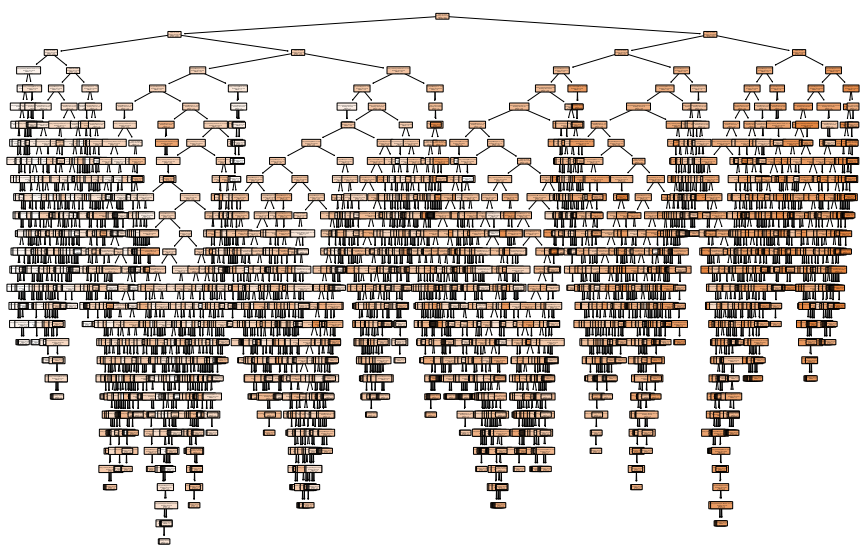

In [36]:
fig = plt.figure(figsize=(15, 10))
plot_tree(rf_model.estimators_[0], 
          feature_names=X.columns,
          class_names=merged_df.margin, 
          filled=True, impurity=True, 
          rounded=True)